In [1]:
import numpy as np
import chess
import chess.pgn
import math
import random
from collections import defaultdict, deque
from tensorflow.keras.models import Sequential 
from tensorflow.keras.models import load_model

C_PUCT = 2.8      
model_type = "positional"
model = load_model(f'{model_type}.keras')

import numpy as np
piece_map = {
    chess.PAWN: 0,
    chess.KNIGHT: 1,
    chess.BISHOP: 2,
    chess.ROOK: 3,
    chess.QUEEN: 4,
    chess.KING: 5
}
def board2tensor_1d(board):
    tensor = np.zeros((12, 64), dtype=np.float32)
    for sq in chess.SQUARES:
        piece = board.piece_at(sq)
        if piece:
            base = piece_map[piece.piece_type]
            if piece.color == chess.BLACK:
                base += 6
            tensor[base, sq] = 1.0
    return tensor.flatten()
def softmax(x):
    exp_x = np.exp(x)
    return exp_x / np.sum(exp_x)


class MCTSNode:
    def __init__(self, board, parent=None, eval=0.0, prior=0.0):
        self.board = board.copy()
        self.parent = parent
        self.children = {}
        self.prior = eval
        self.eval = eval
        self.N = 0
        self.W = 0.0
        self.Q = 0.0
        self.is_expanded = False

    def expand(self):
        legal_moves = list(self.board.generate_legal_moves())
        n = len(legal_moves)

        turn = 1.0
        if self.board.turn: 
            turn = -1.0

        tensors = np.zeros((n, 12 * 64), dtype=np.float32)
        for i, move in enumerate(legal_moves):
            self.board.push(move)
            tensors[i] = board2tensor_1d(self.board)
            self.board.pop()

        evals = model.predict(tensors, verbose=0).flatten()
        evals *= turn
        priors = softmax(evals)
        for move, ev, p in zip(legal_moves, evals, priors):
            self.children[move] = MCTSNode(
                board=self.board,
                parent=self,
                eval=ev,
                prior=p
            )

        self.is_expanded = True
        return self.eval

    @staticmethod
    def uct_score(child, parent_N, c_puct=1.5):
        U = c_puct * child.prior * math.sqrt(parent_N + 1e-8) / (1 + child.N)
        #skaloanie Q
        return child.Q / 5000.0 + U


    def select_child(self):
        parent_N = self.N
        best_move = None
        best_score = -float('inf')

        for move, child in self.children.items():
            score = MCTSNode.uct_score(child, parent_N)
            if score > best_score:
                best_score = score
                best_move = move

        return best_move, self.children[best_move]

    def backpropagate(self, value):
        node = self
        while node is not None:
            node.N += 1
            node.W += value
            node.Q = node.W / node.N
            
            value = -value
            node = node.parent

    def get_policy_value(self):
        policy = self.Q
        if not self.board.turn:  # przywrucenie widoku ze strony białych
            policy *= -1
        return policy


def mcts_search(root, simulations=200):
    for _ in range(simulations):
        node = root

        # Selection
        while node.is_expanded and not node.board.is_game_over():
            move, node = node.select_child()

        # Expansion
        if not node.board.is_game_over():
            value = node.expand()
        else:
            result = node.board.result()
            if result == "1-0":
                value = 5000.0
            elif result == "0-1":
                value = -5000.0
            else:
                value = 0

        # Backpropagation
        node.backpropagate(value)


2026-01-08 19:01:59.841222: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
W0000 00:00:1767895323.108154   11923 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [2]:
from collections import deque

def extract_training_data(root):
    queue = deque([root])
    X, Y = [], []

    while queue:
        node = queue.popleft()

        tensor = board2tensor_1d(node.board)
        X.append(tensor)

        # Q-value jako label
        Y.append(node.get_policy_value())

        for child in node.children.values():
            queue.append(child)

    return np.array(X), np.array(Y)


In [3]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
model = load_model(f'{model_type}.keras')
ITERATIONS = 150
SYMULATIONS = 750
SAVE_INTERVAL = 10

version = 1
historis = []
for iter in range(ITERATIONS):
    root = MCTSNode(chess.Board())
    mcts_search(root, simulations=SYMULATIONS)
    X, Y = extract_training_data(root)

    X = np.array(X)
    Y = np.array(Y).astype(np.float32)
    print("Zebrano przykładów:", X.shape[0])


    X_train, X_val, y_train, y_val = train_test_split(
        X, Y, test_size=0.2, shuffle=True
    )


    model.compile(
        optimizer="adam",
        loss="mse",
        metrics=["mae"]
    )
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=10,
        batch_size=256,
        verbose=1,
        callbacks=[EarlyStopping(patience=3, restore_best_weights=True)]
    )
    historis.append(history)
    if((iter + 1) % SAVE_INTERVAL == 0):
        model.save(f"models/{model_type}_{version}.keras")
        version += 1





2026-01-08 19:02:11.958258: I external/local_xla/xla/service/service.cc:163] XLA service 0x7ac108007a20 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2026-01-08 19:02:11.958271: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): Host, Default Version
2026-01-08 19:02:11.987664: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1767895332.152503   12290 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Zebrano przykładów: 15001
Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 10321.2227 - mae: 78.3496 - val_loss: 404.5083 - val_mae: 20.0317
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 557.9338 - mae: 17.6993 - val_loss: 11.9432 - val_mae: 2.9808
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 129.5258 - mae: 8.7104 - val_loss: 3.2597 - val_mae: 0.5938
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 119.5460 - mae: 8.3775 - val_loss: 3.6900 - val_mae: 1.0947
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 109.5785 - mae: 8.1125 - val_loss: 4.5540 - val_mae: 1.1987
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 102.6714 - mae: 7.9591 - val_loss: 6.5943 - val_mae: 2.1958
Zebrano przykładów: 15001
Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 5041.5381 - mae: 53.6621 - val_loss: 364.5056 - val_mae: 19.0920
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 365.3758 - mae: 13.8270 - val_loss: 1.9276 

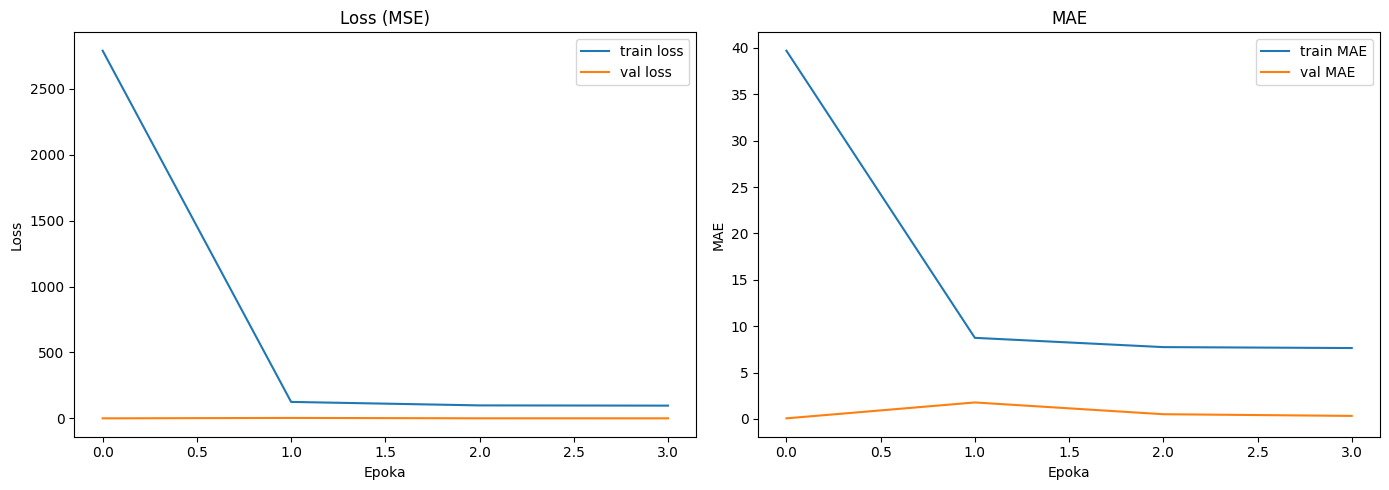

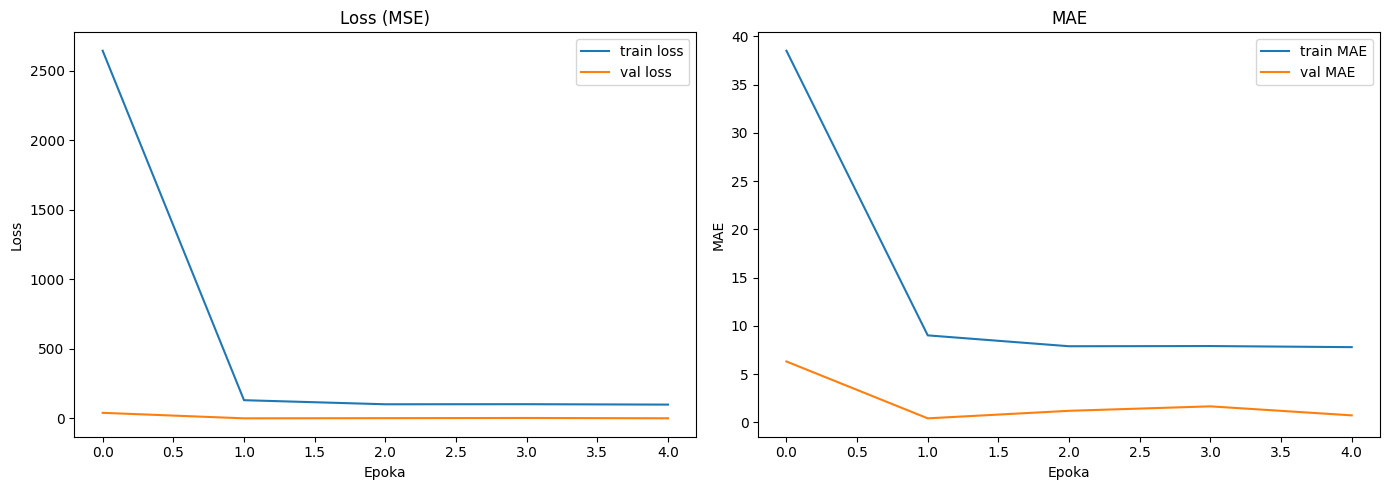

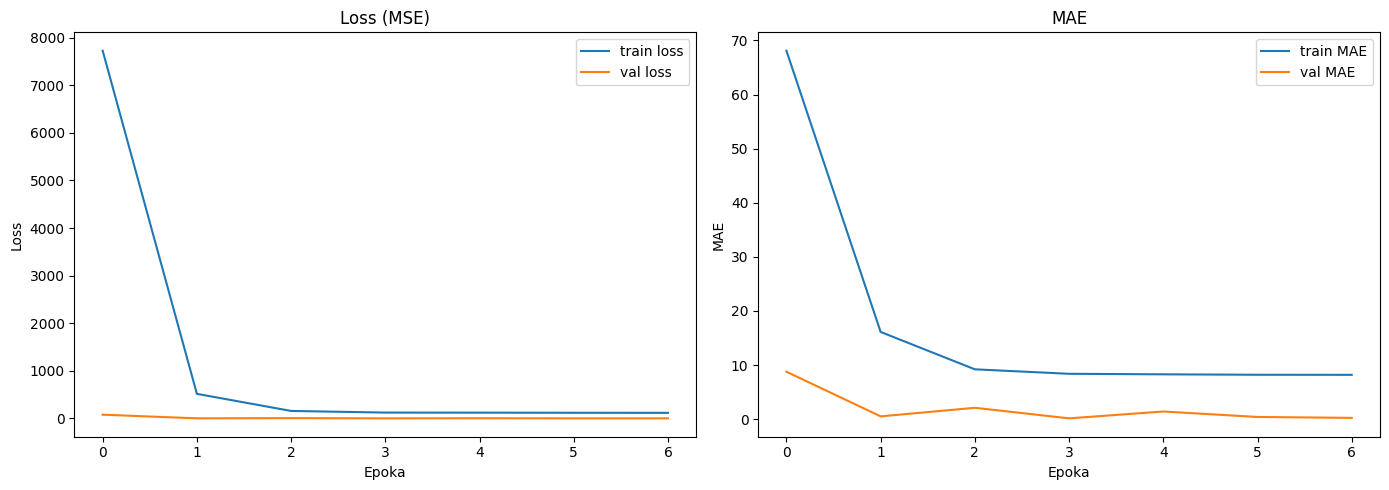

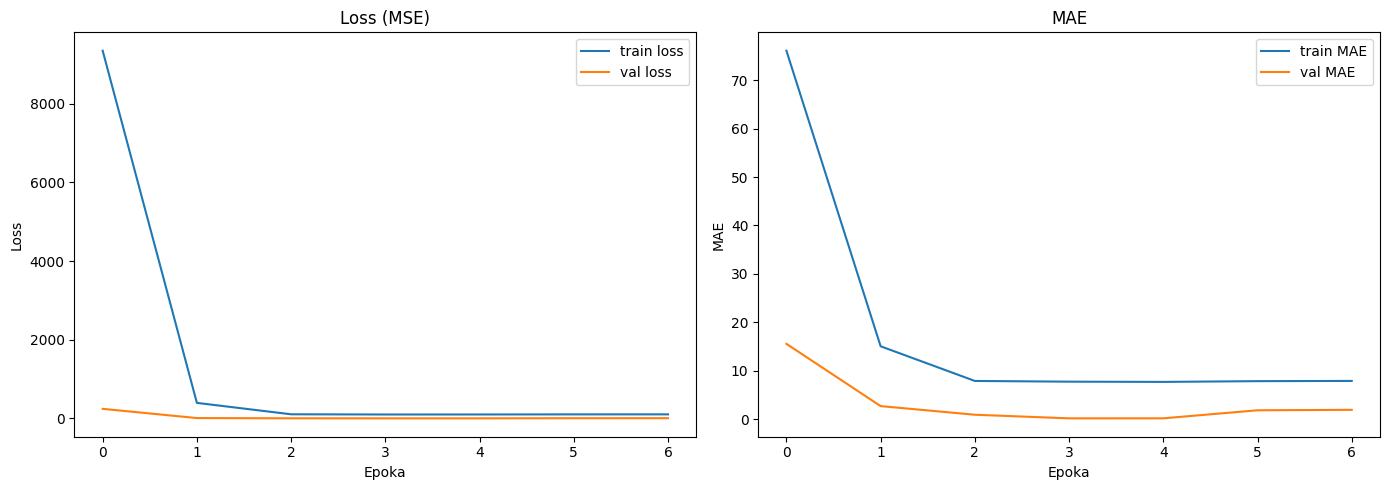

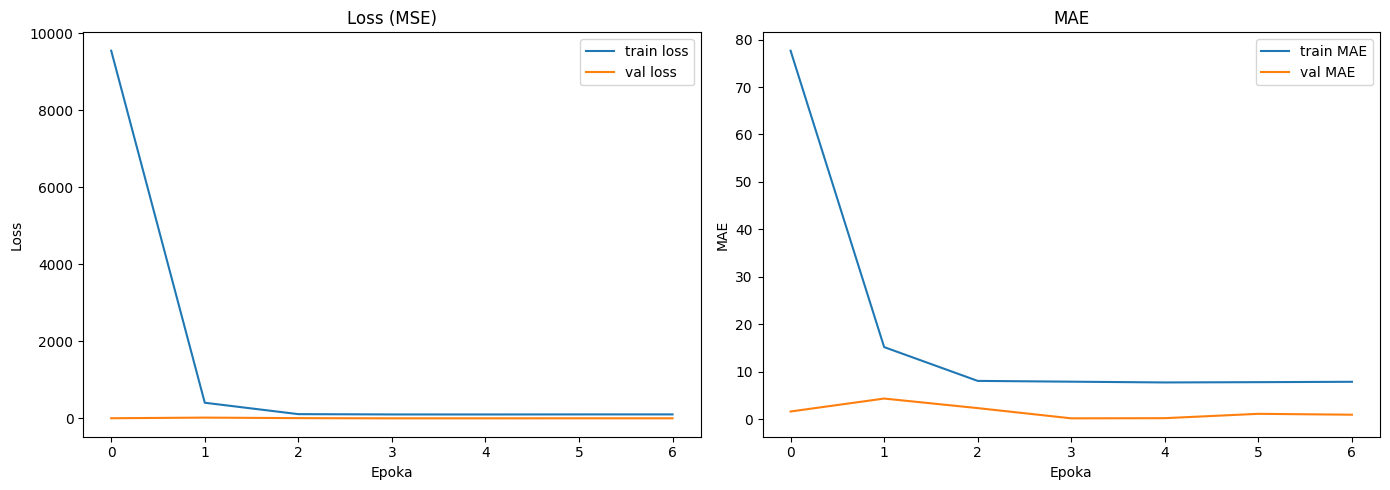

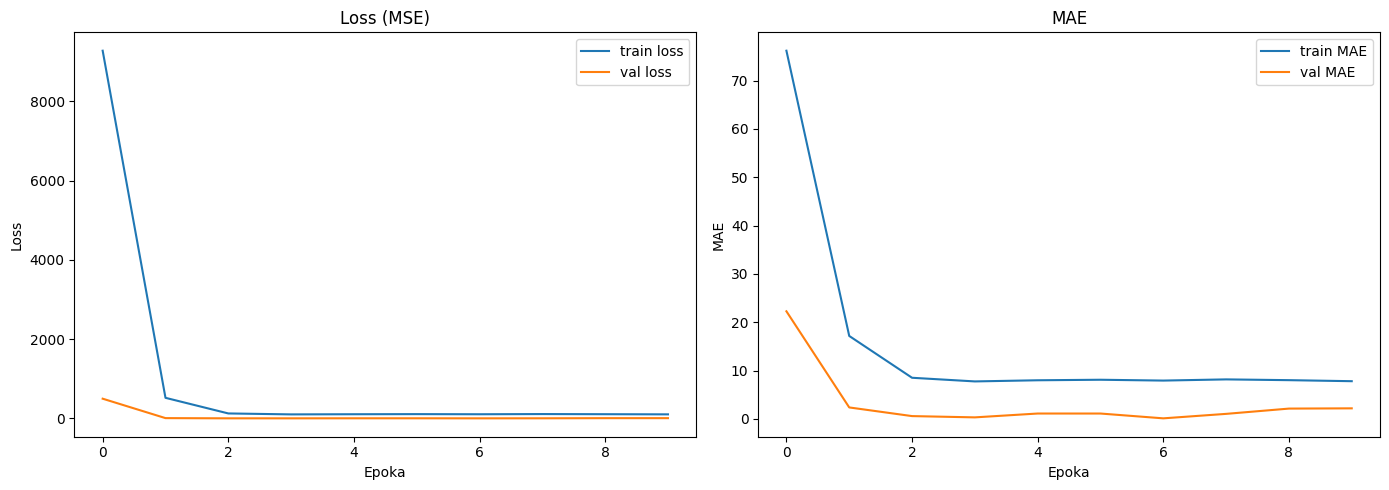

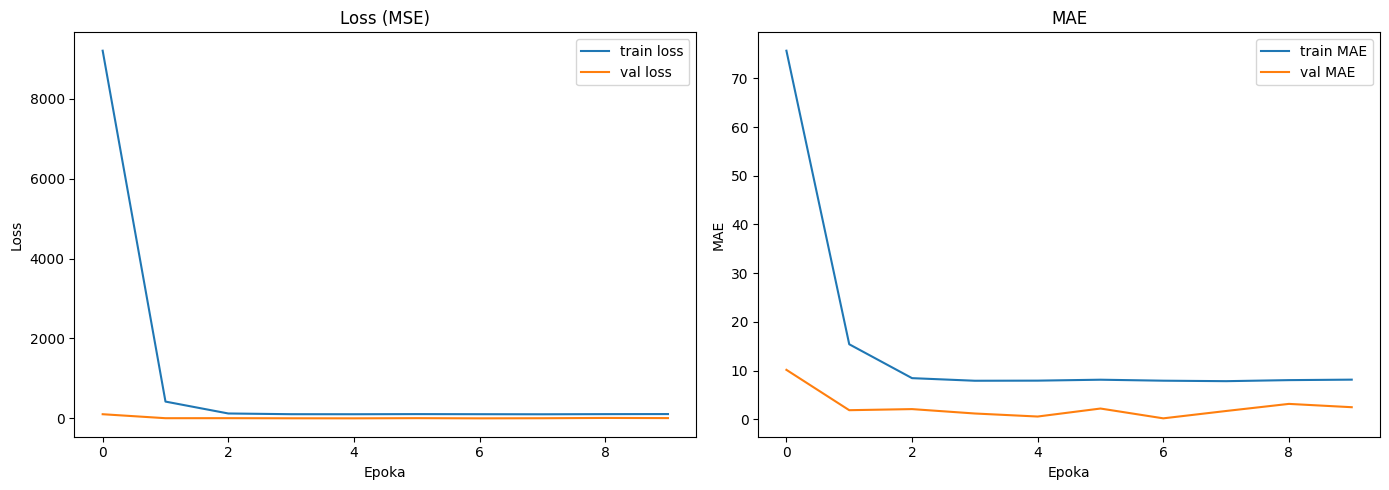

In [4]:
for i in range(1,8):
    history = historis[10 * i]
    plt.figure(figsize=(14,5))
    # ------ Loss ---------
    plt.subplot(1,2,1)
    plt.plot(history.history["loss"], label="train loss")
    plt.plot(history.history["val_loss"], label="val loss")
    plt.title("Loss (MSE)")
    plt.xlabel("Epoka")
    plt.ylabel("Loss")
    plt.legend()

    # ------ MAE ----------
    plt.subplot(1,2,2)
    plt.plot(history.history["mae"], label="train MAE")
    plt.plot(history.history["val_mae"], label="val MAE")
    plt.title("MAE")
    plt.xlabel("Epoka")
    plt.ylabel("MAE")
    plt.legend()

    plt.tight_layout()
    plt.show()